In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

In [2]:
from pymfe.mfe import MFE
import pandas as pd
import time
from preprocessing.tab_preprocessing import get_x_y, get_cat_cols
import seaborn as sns
import warnings
from external.ctgan_repo.ctgan.synthesizers.ctgan_model import CTGAN
from external.ctgan_repo.ctgan.synthesizers.tvae import TVAE
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import entropy
warnings.filterwarnings('ignore')

c:\Users\Anaxagor\anaconda3\envs\tabshift\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def generate_shifted_classification_data(n_samples=500, seed=42):
    """
    Generates source and target classification data with multiple distribution shifts.
    
    Features:
    - x1: Covariate shift (mean change)
    - x2: Variance shift
    - x3, x4: Correlation shift
    - x5: Concept shift (feature importance change)
    
    Labels:
    - Concept shift (changed decision boundary)
    - Prior probability shift (class balance change)
    
    Args:
        n_samples (int): Number of samples per domain
        seed (int): Random seed
        
    Returns:
        source_df, target_df: DataFrames with features and labels
    """
    np.random.seed(seed)
    
    # Generate base features using sklearn's make_classification
    X, y = make_classification(
        n_samples=2*n_samples,
        n_features=5,
        n_informative=3,
        n_redundant=1,
        flip_y=0.05,
        random_state=seed
    )
    
    # Split into source and target base data
    source_X = X[:n_samples]
    source_y = y[:n_samples]
    target_X = X[n_samples:]
    target_y = y[n_samples:]
    
    # Create DataFrame structures
    source_df = pd.DataFrame(source_X, columns=[f'x{i+1}' for i in range(5)])
    source_df['y'] = source_y
    target_df = pd.DataFrame(target_X, columns=[f'x{i+1}' for i in range(5)])
    target_df['y'] = target_y

    # Apply distribution shifts to target domain
    # -------------------------------------------------
    
    # 1. Covariate Shift (x1: mean shift)
    target_df['x1'] = target_df['x1'] + 10.0
    
    # 2. Variance Shift (x2: increased variance)
    target_df['x2'] = target_df['x2'] * 4.5
    
    # # 3. Correlation Shift (x3 & x4: break correlation)
    # target_df['x3'] = np.random.normal(0, 1, n_samples)
    # target_df['x4'] = np.random.normal(0, 1, n_samples)
    
    # # 4. Concept Shift (x5: change relationship with label)
    # # Modify existing labels based on new relationship
    # target_df['y'] = np.where(
    #     (target_df['x5'] > 0.2) & (target_df['x3'] < 0.8),
    #     1 - target_df['y'],  # Flip labels for concept shift
    #     target_df['y']
    # )
    
    # class_0 = target_df[target_df.y == 0]
    # class_1 = target_df[target_df.y == 1]

    # # Calculate desired samples for each class
    # n_class_0 = int(n_samples * 0.8)
    # n_class_1 = int(n_samples * 0.2)

    # # Sample with replacement if needed
    # sampled_class_0 = class_0.sample(n=n_class_0, 
    #                                replace=len(class_0) < n_class_0, 
    #                                random_state=seed)
    # sampled_class_1 = class_1.sample(n=n_class_1, 
    #                                replace=len(class_1) < n_class_1, 
    #                                random_state=seed)

    # target_df = pd.concat([sampled_class_0, sampled_class_1]) \
    #             .sample(frac=1, random_state=seed)  # Shuffle

    return source_df, target_df

# Generate data
source_data, target_data = generate_shifted_classification_data()

# Print dataset summaries
print("Source Data Summary:")
print(f"Class balance: {source_data.y.value_counts(normalize=True).to_dict()}")
print(f"x1 mean: {source_data.x1.mean():.2f}")
print(f"x2 std: {source_data.x2.std():.2f}")
print(f"x3-x4 correlation: {source_data[['x3', 'x4']].corr().iloc[0,1]:.2f}\n")

print("Target Data Summary:")
print(f"Class balance: {target_data.y.value_counts(normalize=True).to_dict()}")
print(f"x1 mean: {target_data.x1.mean():.2f}")
print(f"x2 std: {target_data.x2.std():.2f}")
print(f"x3-x4 correlation: {target_data[['x3', 'x4']].corr().iloc[0,1]:.2f}")

Source Data Summary:
Class balance: {1: 0.514, 0: 0.486}
x1 mean: 0.33
x2 std: 1.27
x3-x4 correlation: -0.03

Target Data Summary:
Class balance: {0: 0.514, 1: 0.486}
x1 mean: 10.39
x2 std: 5.55
x3-x4 correlation: 0.01


In [5]:
total_df = pd.concat([source_data, target_data])
total_df['Domain'] = ['Source']* source_data.shape[0] + ['Target']* target_data.shape[0]


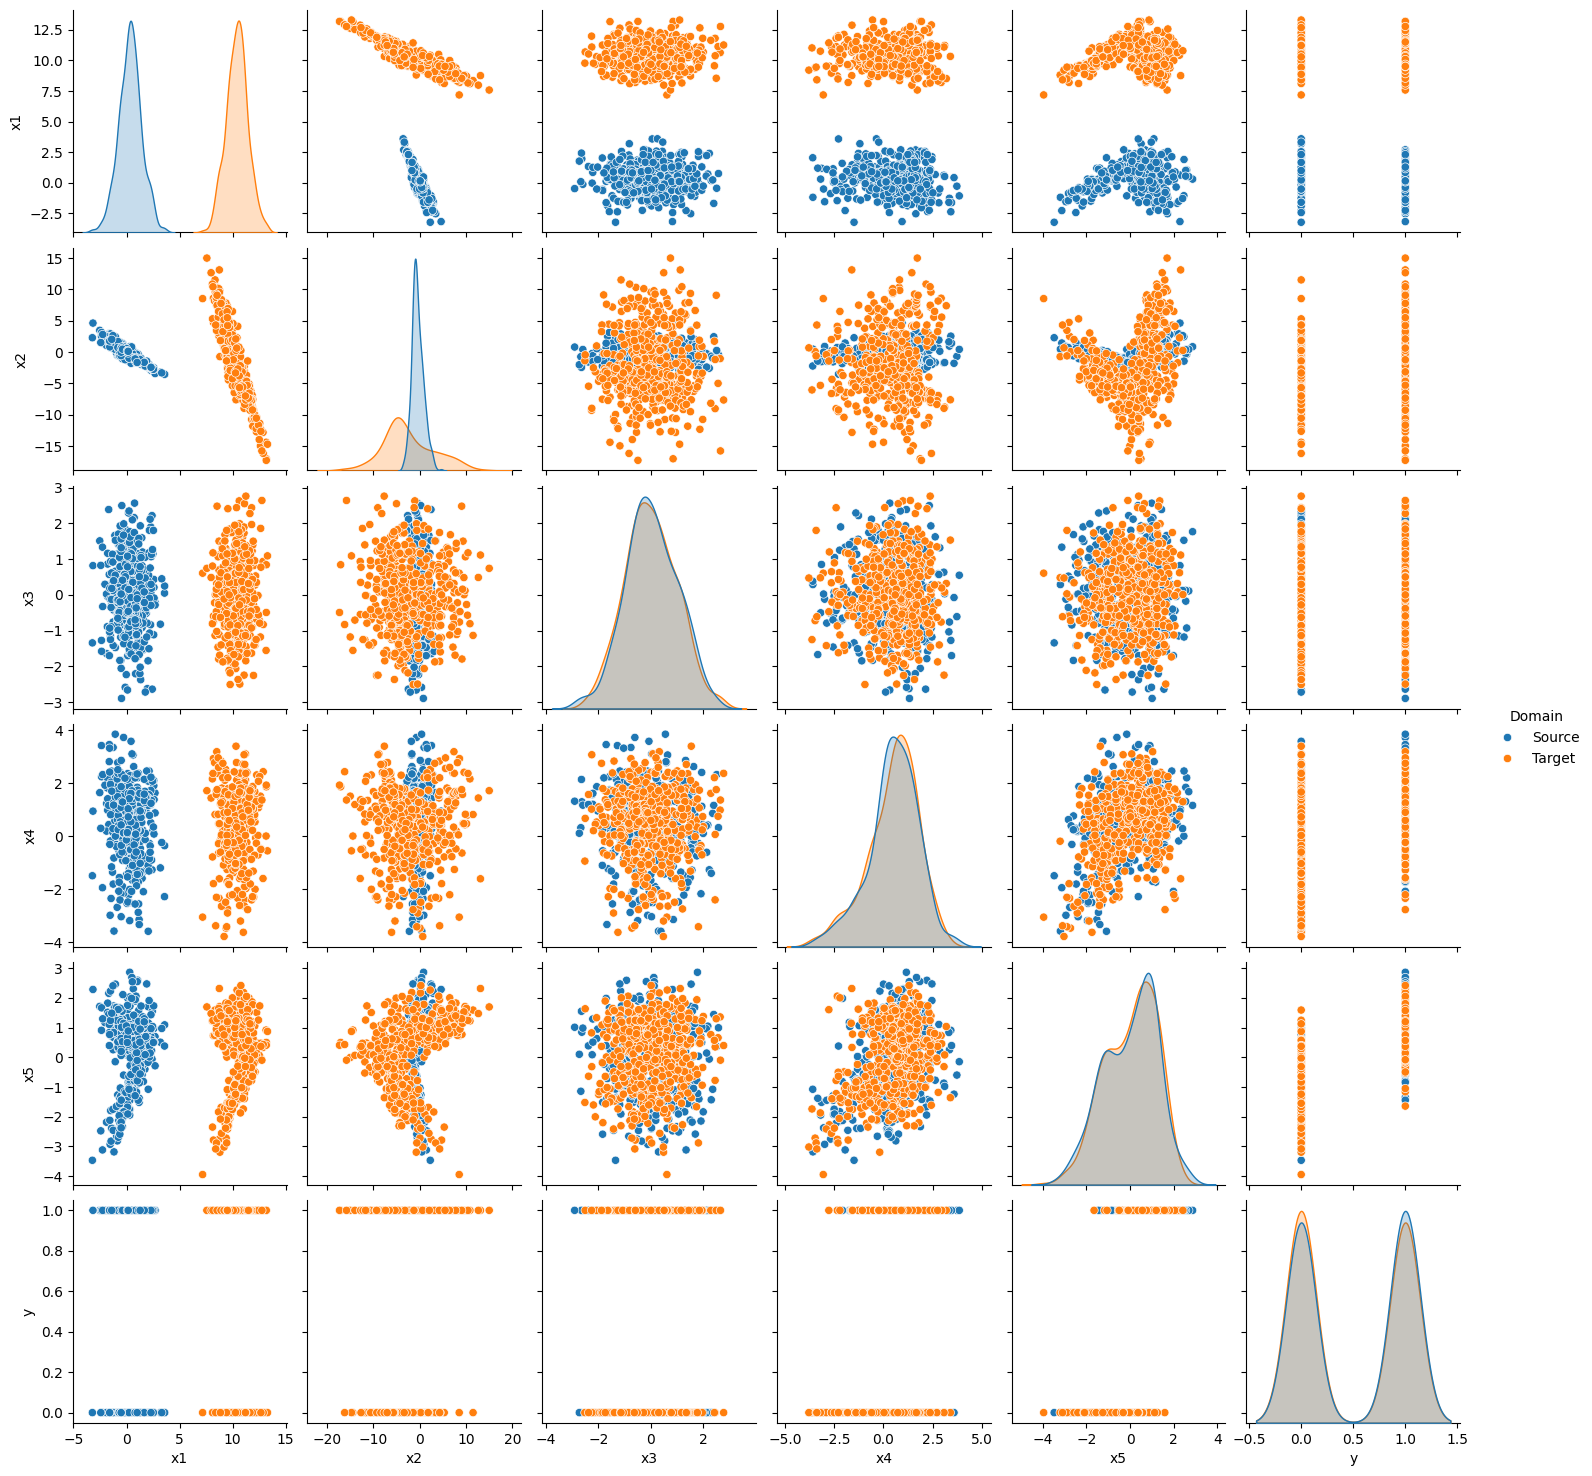

In [6]:
sns.pairplot(total_df, hue='Domain')

In [7]:
X_train, y_train = get_x_y(source_data)
X_test, y_test = get_x_y(target_data)
model = xgb.XGBClassifier()
source_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1'))
model.fit(X_train, y_train)
target_score = f1_score(y_test, model.predict(X_test))
print(source_score)
print(target_score)

0.929079348960537
0.8045540796963947


In [8]:
generator = CTGAN(epochs=300, discriminator_steps=5, batch_size=100, pac=1)
generator.fit(train_data=source_data, discrete_columns=['y'])

In [9]:
sample = generator.sample(n=source_data.shape[0])

In [10]:
X_train, y_train = get_x_y(source_data)
X_sample, y_sample = get_x_y(sample)
model = xgb.XGBClassifier()
source_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1'))
source_score

0.929079348960537

In [11]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
sample_score = f1_score(y_sample, model.predict(X_sample))
sample_score

0.8503937007874016

In [12]:
cont_columns = list(target_data.columns)[:-1]
cont_columns

['x1', 'x2', 'x3', 'x4', 'x5']

In [13]:
source_data[cont_columns].mean(axis=0).to_numpy()


array([ 0.32533165, -0.4696079 ,  0.02090589,  0.48962036,  0.00148387])

In [14]:
sample[cont_columns].mean(axis=0).to_numpy()

array([ 0.05699903, -0.12890946,  0.39007072,  0.20389265, -0.12601478])

In [15]:
target_meta = target_data[cont_columns].mean(axis=0).to_numpy()
target_meta

array([ 1.03903754e+01, -2.40353637e+00, -3.71008693e-03,  4.74499440e-01,
        1.74886933e-02])

In [18]:
import cma
import numpy as np


def optimize_latent_distribution(
    ctgan_model,
    target_means,
    feature_indices=None,
    mode='vector',
    initial_mu=0.0,
    initial_sigma=1.0,
    n_samples=10000,
    sigma0=0.5,
    max_iter=100
):
    """
    Optimize mu and sigma parameters for CTGAN sampling to match target feature means.

    Args:
        ctgan_model: Pre-trained CTGAN model.
        target_means (np.ndarray): Target means for specified features.
        feature_indices (list): Indices of features to compare. If None, use all features.
        mode (str): 'scalar' for single mu/sigma, 'vector' for full vectors.
        initial_mu: Initial mu value(s).
        initial_sigma: Initial sigma value(s).
        n_samples (int): Number of samples per evaluation.
        sigma0 (float): Initial standard deviation for CMA-ES.
        max_iter (int): Maximum number of iterations.

    Returns:
        dict: Optimization results including optimized parameters.
    """
    embedding_dim = ctgan_model._embedding_dim
    device = ctgan_model._device

    if feature_indices is None:
        feature_indices = list(range(len(target_means)))

    def objective_function(x):
        if mode == 'scalar':
            mu = np.full(embedding_dim, x[0])
            sigma = np.full(embedding_dim, x[1])
        elif mode == 'vector':
            mu = x[:embedding_dim]
            sigma = x[embedding_dim:]
        else:
            raise ValueError("Mode must be 'scalar' or 'vector'")

        # Generate samples with current mu/sigma
        synthetic_data = ctgan_model.sample(
            n=n_samples,
            mu=mu,
            sigma=sigma
        )

        # Convert to numpy if DataFrame
        if hasattr(synthetic_data, 'values'):
            synthetic_data = synthetic_data.values

        # Calculate mean of relevant features
        synthetic_means = np.mean(synthetic_data[:, feature_indices], axis=0)

        # Compute Mean Squared Error
        mse = np.mean((synthetic_means - target_means) ** 2)
        return mse

    # Initialize CMA-ES based on mode
    if mode == 'scalar':
        initial_guess = [initial_mu, initial_sigma]
        bounds = [[-10, 0.1], [10, 10]]  # [mu_min, sigma_min], [mu_max, sigma_max]
    else:
        initial_guess = np.concatenate([
            np.full(embedding_dim, initial_mu),
            np.full(embedding_dim, initial_sigma)
        ])
        bounds = [[-10] * embedding_dim + [0.1] * embedding_dim,
                  [10] * embedding_dim + [10] * embedding_dim]

    # Run CMA-ES optimization
    es = cma.CMAEvolutionStrategy(initial_guess, sigma0, {'bounds': bounds, 'maxiter': max_iter})
    es.optimize(objective_function)

    # Extract best solution
    best_solution = es.result.xbest
    best_loss = es.result.fbest

    if mode == 'scalar':
        optimized_mu = best_solution[0]
        optimized_sigma = best_solution[1]
    else:
        optimized_mu = best_solution[:embedding_dim]
        optimized_sigma = best_solution[embedding_dim:]

    return {
        'mu': optimized_mu,
        'sigma': optimized_sigma,
        'loss': best_loss,
        'cma_es_result': es.result
    }

# Example usage:
# Assuming `ctgan` is a trained CTGAN model and `target_means` is defined
result = optimize_latent_distribution(
    ctgan_model=generator,
    target_means=target_meta,
    feature_indices=[0,1,2,3,4],  # Indices of features to match
    mode='vector',
    n_samples=5000,
    sigma0=0.2,
    max_iter=50
)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 256 (seed=714702, Mon Oct 27 15:34:52 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 2.165799279848597e+01 1.0e+00 1.96e-01  2e-01  2e-01 0:02.9
    2     40 2.077383864904233e+01 1.0e+00 1.92e-01  2e-01  2e-01 0:05.5
    3     60 1.959098954875293e+01 1.0e+00 1.89e-01  2e-01  2e-01 0:08.3
    4     80 1.913892948732138e+01 1.0e+00 1.86e-01  2e-01  2e-01 0:11.5
    6    120 1.782453207161460e+01 1.0e+00 1.81e-01  2e-01  2e-01 0:16.8
    8    160 1.677496148698503e+01 1.0e+00 1.78e-01  2e-01  2e-01 0:22.1
   11    220 1.516384104065286e+01 1.0e+00 1.75e-01  2e-01  2e-01 0:29.9
   14    280 1.373980178647846e+01 1.0e+00 1.73e-01  2e-01  2e-01 0:38.0
   17    340 1.323808445061449e+01 1.0e+00 1.73e-01  2e-01  2e-01 0:47.2
   21    420 1.196500523414902e+01 1.0e+00 1.74e-01  2e-01  2e-01 0:58.7
   25    500 1.125828017695185e+01 1.0e+00 1.76e-01  2e-01  2e-01 1:10.5
   29    580 1.055352485719646e

In [19]:
result

{'mu': array([ 0.94703218,  0.27520615,  1.84306839,  0.50730379, -0.22521312,
        -0.8496404 , -1.23696314,  1.89541544, -0.09192681,  0.35822518,
        -0.8855863 , -0.24261884,  1.53323165, -0.50779121, -0.39834155,
         0.5186211 ,  1.8471584 , -0.75060651, -0.05165963,  1.25467175,
         1.0806639 ,  0.23029991,  0.0280486 ,  0.05178798,  0.14173189,
        -0.70937556,  1.84468452, -2.11852484,  0.35635487,  0.23994779,
        -0.40202134, -1.12766346, -0.26096784, -0.4426354 ,  0.66830687,
        -1.06315811, -0.72467601, -0.02239972, -0.52254596, -0.89488553,
        -0.67196977,  1.1397161 , -0.08227591, -1.34586887, -1.38849261,
         1.94585357,  0.20391537,  2.28652876,  0.49046333, -0.76634796,
        -1.28986431, -1.20142502, -1.72216518,  0.33233191, -0.01351339,
         1.50688451, -0.78246842, -0.55511307, -0.18187158, -1.11658195,
         0.73101699, -0.23916663, -0.28595297,  1.0912465 , -0.55896642,
        -0.38484023,  0.29250535, -0.70851176

In [20]:
sample_new = generator.sample(n=source_data.shape[0], mu=result['mu'], sigma=result['sigma'])

In [21]:
new_df = pd.concat([source_data, target_data, sample, sample_new])
new_df['Domain'] = ['source']*500 + ['target']*500 + ['synth']*500 + ['shifted_synth']*500

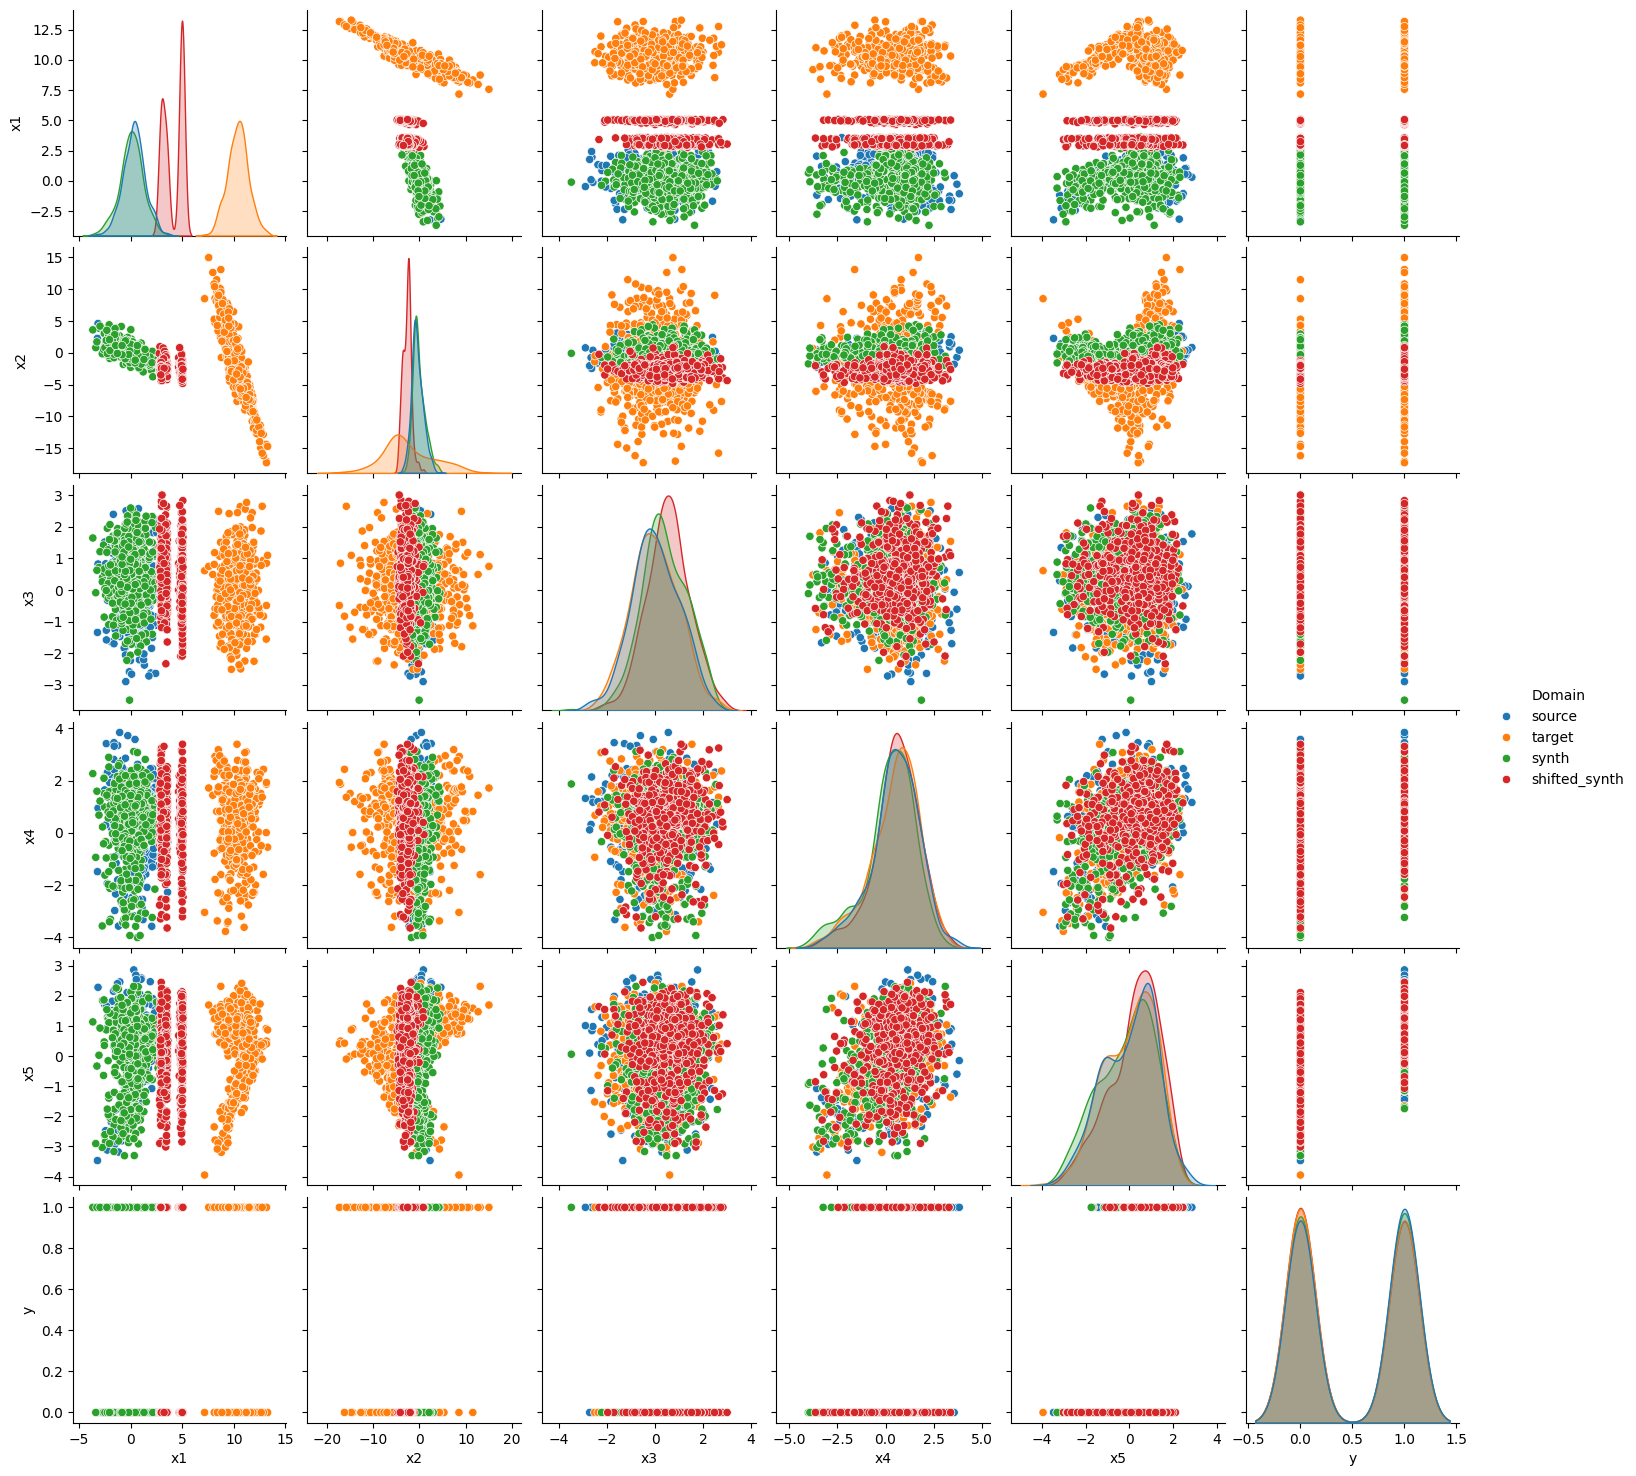

In [22]:
sns.pairplot(new_df, hue='Domain')